# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [34]:
# import all improtant libraries
# Import necessary libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan, when, count, col, hour, udf, countDistinct, desc, avg, from_unixtime, to_date, ceil, min
from pyspark.sql.types import StringType, DateType, IntegerType
from pyspark.sql.functions import max as Fmax, sum as Fsum
from pyspark.sql.functions import avg as Favg, countDistinct, count
import seaborn as sns
from pyspark.sql import Window
import datetime
from pyspark.sql.functions import hour, dayofweek, month, from_unixtime
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.sql.functions import count, countDistinct, avg, max, min, col, hour, dayofweek, datediff, to_date, when
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, countDistinct, avg, max, min, col, hour, dayofweek, datediff, to_date, when, sum, lead, current_date, month
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler

from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plot
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt




In [35]:
# Create a Spark session
#spark = SparkSession.builder \
#    .appName("SparkifyAppinML") \
#    .getOrCreate()

spark = SparkSession.builder \
    .appName("SparkifyAppinML") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()




# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [36]:
# Load the JSON data into a Spark DataFrame
df = spark.read.json("mini_sparkify_event_data.json")

# Show the DataFrame
df.show(5)
# Print the schema of the DataFrame
df.printSchema()


+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [37]:
# Fetch the first row of the DataFrame
first_row = df.head()

# Display the first row
print(first_row)


Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')


In [38]:
# Getting the number of rows
num_rows = df.count()

# Getting the number of columns
num_columns = len(df.columns)

# Print the shape
print(f"Shape of the DataFrame: ({num_rows}, {num_columns})")


Shape of the DataFrame: (286500, 18)


In [39]:

# Checking for missing values in each column including Nulls
null_counts = df.select([F.count(F.when(F.col(i).isNull(), i)).alias(i) for i in df.columns])

# Show the results
null_counts.show(truncate=False)


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song |status|ts |userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|58392 |0   |8346     |8346  |0            |8346    |58392 |0    |8346    |0     |0   |8346        |0        |58392|0     |0  |8346     |0     |
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [40]:
# Filter and counting rows, where 'gender' column is null
null_registration_count = df.filter(df["gender"].isNull()).count()

# Print the count
print(f"Number of rows where 'gender' is null: {null_registration_count}")


Number of rows where 'gender' is null: 8346


In [41]:
df.filter(df["gender"].isNull()).show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  NULL|Logged Out|     NULL|  NULL|          100|    NULL|  NULL| free|    NULL|   GET| Home|        NULL|        8|NULL|   200|1538355745000|     NULL|      |
|  NULL|Logged Out|     NULL|  NULL|          101|    NULL|  NULL| free|    NULL|   GET| Help|        NULL|        8|NULL|   200|1538355807000|     NULL|      |
|  NULL|Logged Out|     NULL|  NULL|          102|    NULL|  NULL| free|    NULL|   GET| Home|        NULL|        8|NULL|   200|1538355841000|     NULL|      |
|  NULL|Logged Out|     NULL|  NUL

In [42]:
# Drop rows where 'gender' column is null, subsequently dropping other nulls
df = df.dropna(how="any", subset=["gender"])


In [43]:
# Define columns to drop where they have similar Nulls
df_clean = df.na.drop(subset=['firstName','registration'])

In [44]:


#df_clean is your DataFrame
df_clean.select([count(when(col(i).isNull(), i)).alias(i) for i in df_clean.columns]).show()


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [45]:
df_clean.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Subscription Level Features

In [46]:
#number of uniques values in each column
df_clean.toPandas().nunique()

artist            17655
auth                  2
firstName           189
gender                2
itemInSession      1311
lastName            173
length            14865
level                 2
location            114
method                2
page                 19
registration        225
sessionId          2312
song              58480
status                3
ts               269770
userAgent            56
userId              225
dtype: int64

In [47]:
# extracting disinct values in the page column

# Count the occurrences of each page
df_clean.groupBy('page').count().show()

# Count the occurrences of each level
df_clean.groupBy('level').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



In [48]:
# Create a 'cancelled' column to workout churn
df_clean = df_clean.withColumn('cancelled', when(df_clean.page == 'Cancellation Confirmation', 1).otherwise(0))
df_clean.show(5)


+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|cancelled|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|        0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambr

In [49]:
# Create a column 'downgrade' that indicates whether a user has downgraded
df_clean = df_clean.withColumn('downgrade', when(df_clean.page == 'Submit Downgrade', 1).otherwise(0))
df_clean.show(5)

# Aggregate downgrade for each user
user_downgrade = df_clean.groupBy('userId').agg(Fsum('downgrade').alias('numDowngrades'))
user_downgrade.show(5)


+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+---------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|cancelled|downgrade|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+---------+---------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|        0|        0|
|Five Iron Frenzy|Logged In|    Micah|     M|           

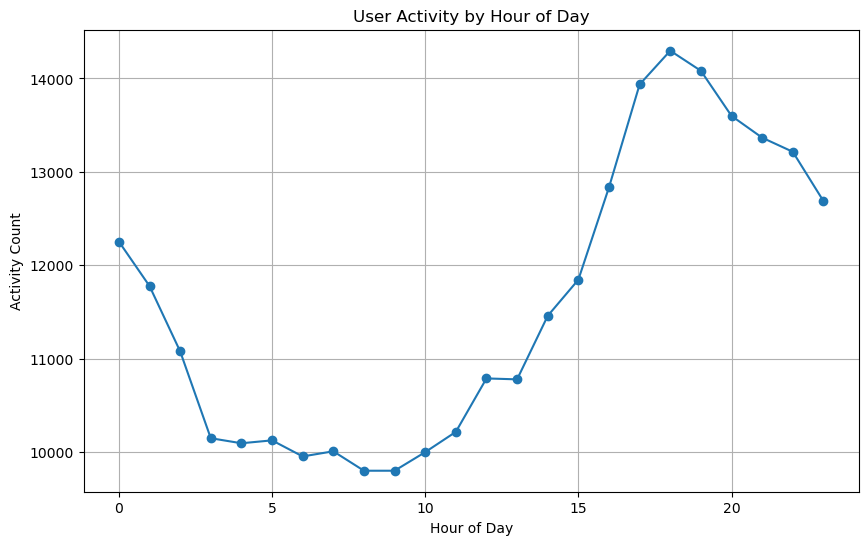

In [50]:
# Extract hour from timestamp
df_clean = df_clean.withColumn('hour', hour((df_clean['ts'] / 1000).cast('timestamp')))

# Group by hour to see activity over the day
hourly_activity = df_clean.groupBy('hour').count().orderBy('hour').toPandas()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.plot(hourly_activity['hour'], hourly_activity['count'], marker='o', linestyle='-')
plt.xlabel('Hour of Day')
plt.ylabel('Activity Count')
plt.title('User Activity by Hour of Day')
plt.grid(True)
plt.show()


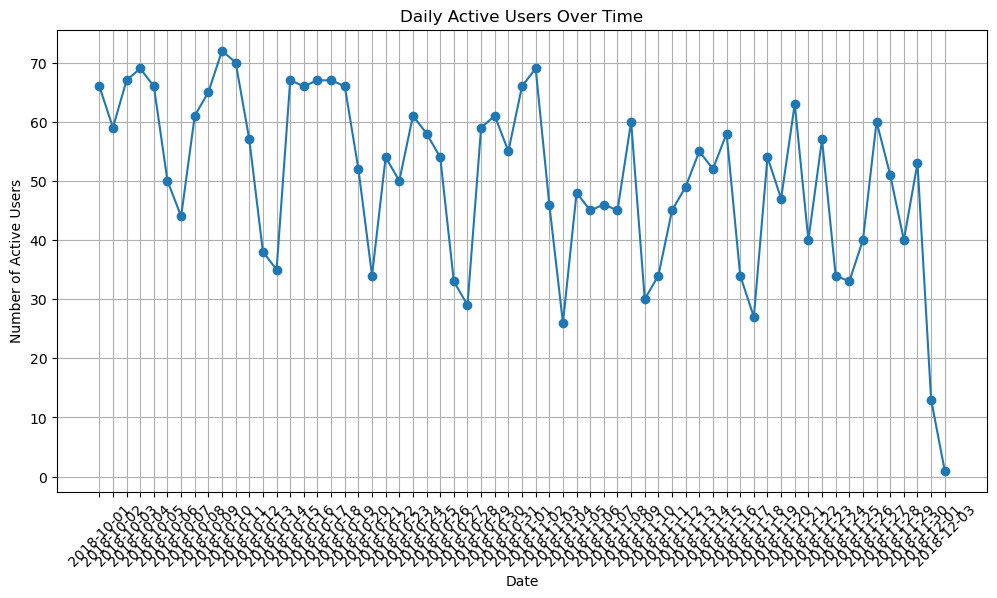

In [51]:
from pyspark.sql.functions import date_format

# Extract date from timestamp
df_clean = df_clean.withColumn('date', date_format((df_clean['ts'] / 1000).cast('timestamp'), 'yyyy-MM-dd'))

# Group by date to see daily active users
daily_active_users = df_clean.groupBy('date').agg(F.countDistinct('userId').alias('active_users')).orderBy('date').toPandas()

# Plot the retention
plt.figure(figsize=(12, 6))
plt.plot(daily_active_users['date'], daily_active_users['active_users'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Active Users')
plt.title('Daily Active Users Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [52]:
# Count the number of cancellations and downgrades
cancellations = df_clean.filter(df_clean['cancelled'] == 1).count()
downgrades = df_clean.filter(df_clean['downgrade'] == 1).count()

print(f'Number of Cancellations: {cancellations}')
print(f'Number of Downgrades: {downgrades}')


Number of Cancellations: 52
Number of Downgrades: 63


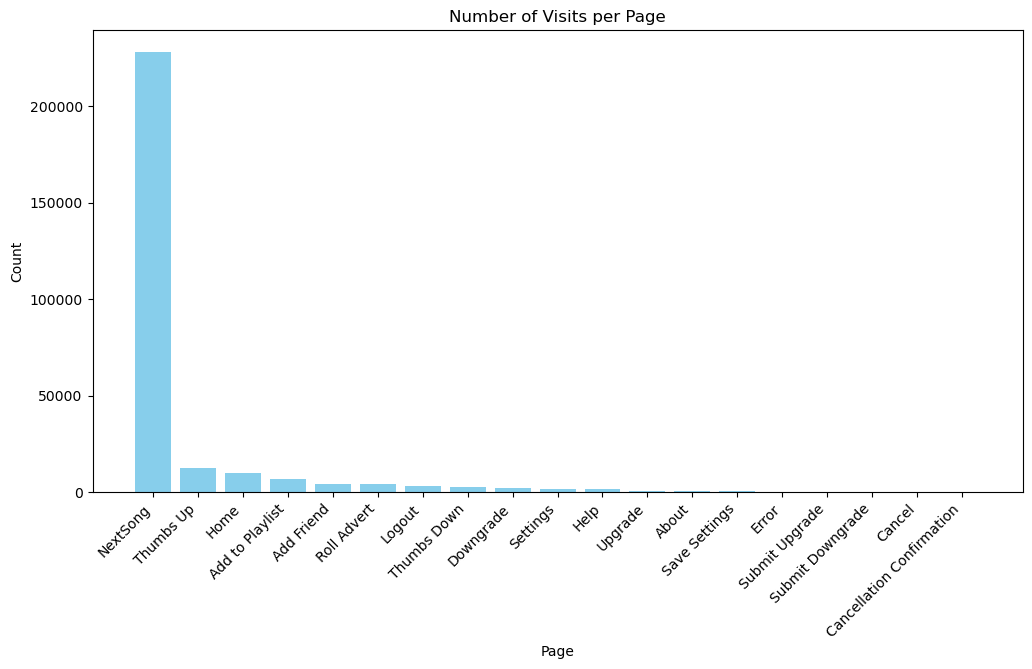

In [53]:
# Collect data for plotting
page_visits = df_clean.groupBy('page').count().orderBy('count', ascending=False).toPandas()

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(page_visits['page'], page_visits['count'], color='skyblue')
plt.xlabel('Page')
plt.ylabel('Count')
plt.title('Number of Visits per Page')
plt.xticks(rotation=45, ha='right')
plt.show()


### Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.




In [54]:

#Create a column 'churn' that indicates whether a user has cancelled
from pyspark.sql.functions import col, when, max as Fmax
from pyspark.sql.window import Window

# Create a 'cancelled' column to indicate churn based on cancellation confirmation
df_clean = df_clean.withColumn('cancelled', when(df_clean.page == 'Cancellation Confirmation', 1).otherwise(0))

# Create a 'downgrade' column to indicate churn based on downgrade submissions
df_clean = df_clean.withColumn('downgrade', when((df_clean.level == 'paid') & (df_clean.page == 'Submit Downgrade'), 1).otherwise(0))

# Define churn by checking if a user has either cancellation confirmation or downgrade submission
df_clean = df_clean.withColumn('churn', Fmax(when((df_clean.cancelled == 1) | (df_clean.downgrade == 1), 1).otherwise(0)).over(Window.partitionBy('userId')))

# Verify the churn column
df_clean.select('userId', 'churn').drop_duplicates().show(5)


+------+-----+
|userId|churn|
+------+-----+
|    10|    0|
|   100|    1|
|100001|    1|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



In [55]:
# Count interactions (page views) per user
interactions_per_user = df_clean.groupBy('userId').agg(F.count('page').alias('totalInteractions'))


In [56]:
# Total duration of interactions per user
total_duration_per_user = df_clean.groupBy('userId').agg(F.sum('length').alias('totalDuration'))


In [57]:
# Join interactions with level
user_interactions_with_level = df_clean.groupBy('userId', 'level').agg(F.count('page').alias('totalInteractions'))
user_duration_with_level = df_clean.groupBy('userId', 'level').agg(F.sum('length').alias('totalDuration'))

# Aggregate metrics by level
interactions_by_level = user_interactions_with_level.groupBy('level').agg(
    F.avg('totalInteractions').alias('avgInteractions'),
    F.sum('totalInteractions').alias('totalInteractions')
)

duration_by_level = user_duration_with_level.groupBy('level').agg(
    F.avg('totalDuration').alias('avgDuration'),
    F.sum('totalDuration').alias('totalDuration')
)



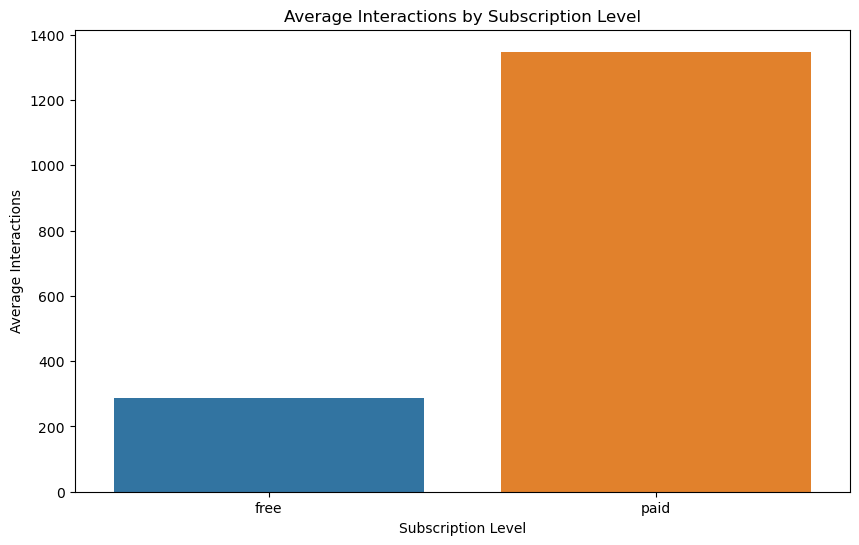

In [58]:
# Convert Spark DataFrame to Pandas DataFrame
interactions_by_level_pd = interactions_by_level.toPandas()

# Plot average interactions by level
plt.figure(figsize=(10, 6))
sns.barplot(x='level', y='avgInteractions', data=interactions_by_level_pd)
plt.title('Average Interactions by Subscription Level')
plt.xlabel('Subscription Level')
plt.ylabel('Average Interactions')
plt.show()


In [59]:

# Session Frequency (sessions per week)
# Calculate session frequency
session_freq = df_clean.groupBy('userId').agg(
    (count('sessionId') / (datediff(max(to_date((df_clean.ts / 1000).cast('timestamp'))), 
                                   min(to_date((df_clean.ts / 1000).cast('timestamp')))) / 7)).alias('sessionFreq')
)
df_clean = df_clean.join(session_freq, 'userId', 'left')


+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



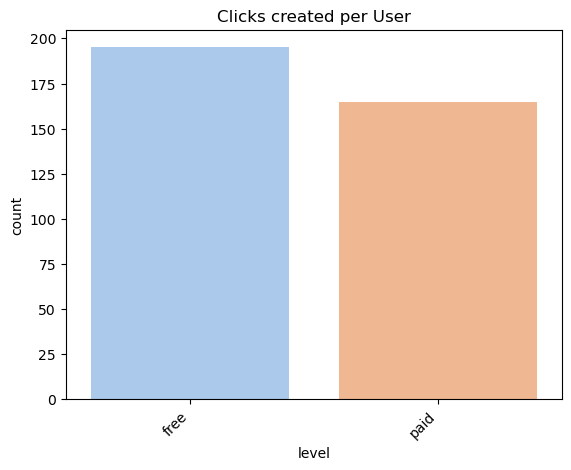

In [60]:
# Select Distinct Users and Levels
df_levels = df_clean.select('userId', 'level').distinct()

# Group by Level and Count
level_counts = df_levels.groupBy('level').count()
level_counts.show()

# Convert to Pandas DataFrame
level_counts_pandas = level_counts.toPandas()

# Plot the User Levels using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plot_lev = sns.barplot(data=level_counts_pandas, x='level', y='count', palette='pastel')
plot_lev.set_xticklabels(plot_lev.get_xticklabels(), rotation=45, horizontalalignment='right')
plot_lev.set_title("Clicks created per User")
plt.show()


In [61]:
from pyspark.sql import Window
from pyspark.sql.functions import lead, col, to_date, datediff, max

# Create a window specification for user sessions
window_spec = Window.partitionBy('userId').orderBy('ts')

# Calculate session inactivity
session_inactivity = df_clean.withColumn('lead_ts', lead('ts').over(window_spec))
session_inactivity = session_inactivity.withColumn(
    'inactivityPeriod',
    datediff(to_date((col('lead_ts') / 1000).cast('timestamp')), to_date((col('ts') / 1000).cast('timestamp')))
)

# Group by userId to get the maximum inactivity period for each user
session_inactivity = session_inactivity.groupBy('userId').agg(max('inactivityPeriod').alias('maxInactivity'))

# Join the calculated max inactivity period back to the original dataframe
df_clean = df_clean.join(session_inactivity, 'userId', 'left')

# Show the first 10 rows to verify the result
df_clean.select('userId', 'maxInactivity').show(10, truncate=False)


+------+-------------+
|userId|maxInactivity|
+------+-------------+
|30    |9            |
|30    |9            |
|30    |9            |
|30    |9            |
|30    |9            |
|30    |9            |
|9     |7            |
|9     |7            |
|9     |7            |
|9     |7            |
+------+-------------+
only showing top 10 rows



In [62]:
#  Group by userId and Aggregate Total Length of Songs
df_agg = df_clean.groupBy('userId', 'firstName', 'lastName', 'level', 'churn').sum('length')

# Convert to Pandas DataFrame
df_agg_pandas = df_agg.drop_duplicates().toPandas()

# Sort by Total Length of Songs Listened
df_sorted = df_agg_pandas.sort_values(by='sum(length)', ascending=False)

#  Select Top 10 Users
top_10_users = df_sorted.head(10)
top_10_users


,userId,firstName,lastName,level,churn,sum(length)
285,39,Payton,Campbell,paid,1,1.638520e+06
352,92,Riley,Taylor,paid,1,1.275323e+06
35,140,Lucero,Reed,paid,1,1.179657e+06
257,300011,Emilia,House,paid,1,1.096867e+06
21,124,Nicole,Beck,paid,0,1.012312e+06
267,300021,Emma,Allen,paid,1,9.408994e+05
67,300017,Alyssia,Campbell,paid,0,8.974070e+05
74,42,Dillyn,Richardson,paid,0,8.572977e+05
100,85,Brayden,Thomas,paid,1,7.920673e+05
311,6,Bryson,Roberson,paid,0,7.715731e+05


+-----+-----+
|churn|count|
+-----+-----+
|    1|   92|
|    0|  133|
+-----+-----+



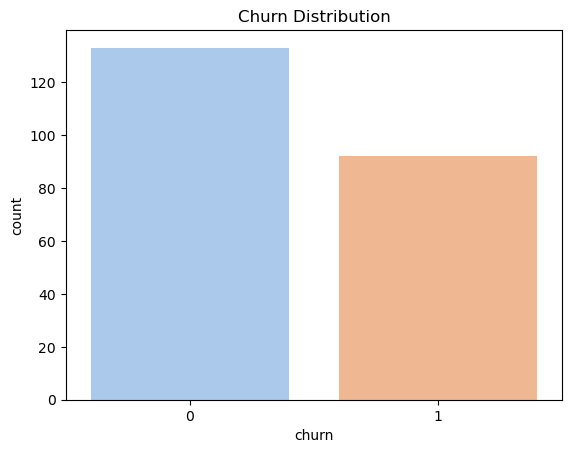

In [63]:
# Select and Drop Duplicates
df_churn = df_clean.select(['userId', 'churn']).dropDuplicates()

#  Group by Churn and Count
churn_counts = df_churn.groupBy('churn').count()
churn_counts.show()

#  Convert to Pandas DataFrame
churn_counts_pandas = churn_counts.toPandas()

# Plot the Churn Distribution using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

churn_plt = sns.barplot(data=churn_counts_pandas, x='churn', y='count', palette='pastel')
churn_plt.set_title('Churn Distribution')
plt.show()


In [64]:
# Calculate total duration
total_duration = df_clean.groupBy('userId').agg(sum('length').alias('totalDuration'))
df_clean = df_clean.join(total_duration, 'userId', 'left')


In [65]:
thumbs_up = df_clean.groupBy('userId').agg(
    count(when(col('page') == 'Thumbs Up', 1)).alias('thumbsUp')
)
df_clean = df_clean.join(thumbs_up, 'userId', 'left')


In [66]:
thumbs_down = df_clean.groupBy('userId').agg(
    count(when(col('page') == 'Thumbs Down', 1)).alias('thumbsDown')
)
df_clean = df_clean.join(thumbs_down, 'userId', 'left')


In [67]:
# Calculate skipped songs
skipped_songs = df_clean.withColumn('next_song', lead('song', 1).over(window_spec))
skipped_songs = skipped_songs.filter(df_clean.page == 'NextSong').groupBy('userId').agg(
    count(when((col('song').isNotNull()) & (col('next_song') != col('song')), 1)).alias('skippedSongs')
)
df_clean = df_clean.join(skipped_songs, 'userId', 'left')


In [68]:
# Calculate days since registration
days_since_reg = df_clean.groupBy('userId').agg(
    (datediff(current_date(), min(to_date((col('registration') / 1000).cast('timestamp'))))).alias('daysSinceReg')
)
df_clean = df_clean.join(days_since_reg, 'userId', 'left')


In [69]:
# Calculate churn seasonality
df_clean = df_clean.withColumn('month', month(to_date((df_clean.ts / 1000).cast('timestamp'))))
seasonality = df_clean.groupBy('userId', 'month').agg(count('page').alias('seasonalActivity'))
df_clean = df_clean.join(seasonality, 'userId', 'left')


In [70]:
# Calculate favorite artist
favorite_artist = df_clean.groupBy('userId', 'artist').agg(count('page').alias('artistPlays'))
favorite_artist = favorite_artist.groupBy('userId').agg(max('artistPlays').alias('favoriteArtistPlays'))
#df_clean = df_clean.join(favorite_artist, 'userId', 'left')

# Calculate favorite song
favorite_song = df_clean.groupBy('userId', 'song').agg(count('page').alias('songPlays'))
favorite_song = favorite_song.groupBy('userId').agg(max('songPlays').alias('favoriteSongPlays'))
#df_clean = df_clean.join(favorite_song, 'userId', 'left')


In [71]:
df_clean = df_clean.withColumn('genders', F.when(df_clean.gender == "F", 1).otherwise(0))


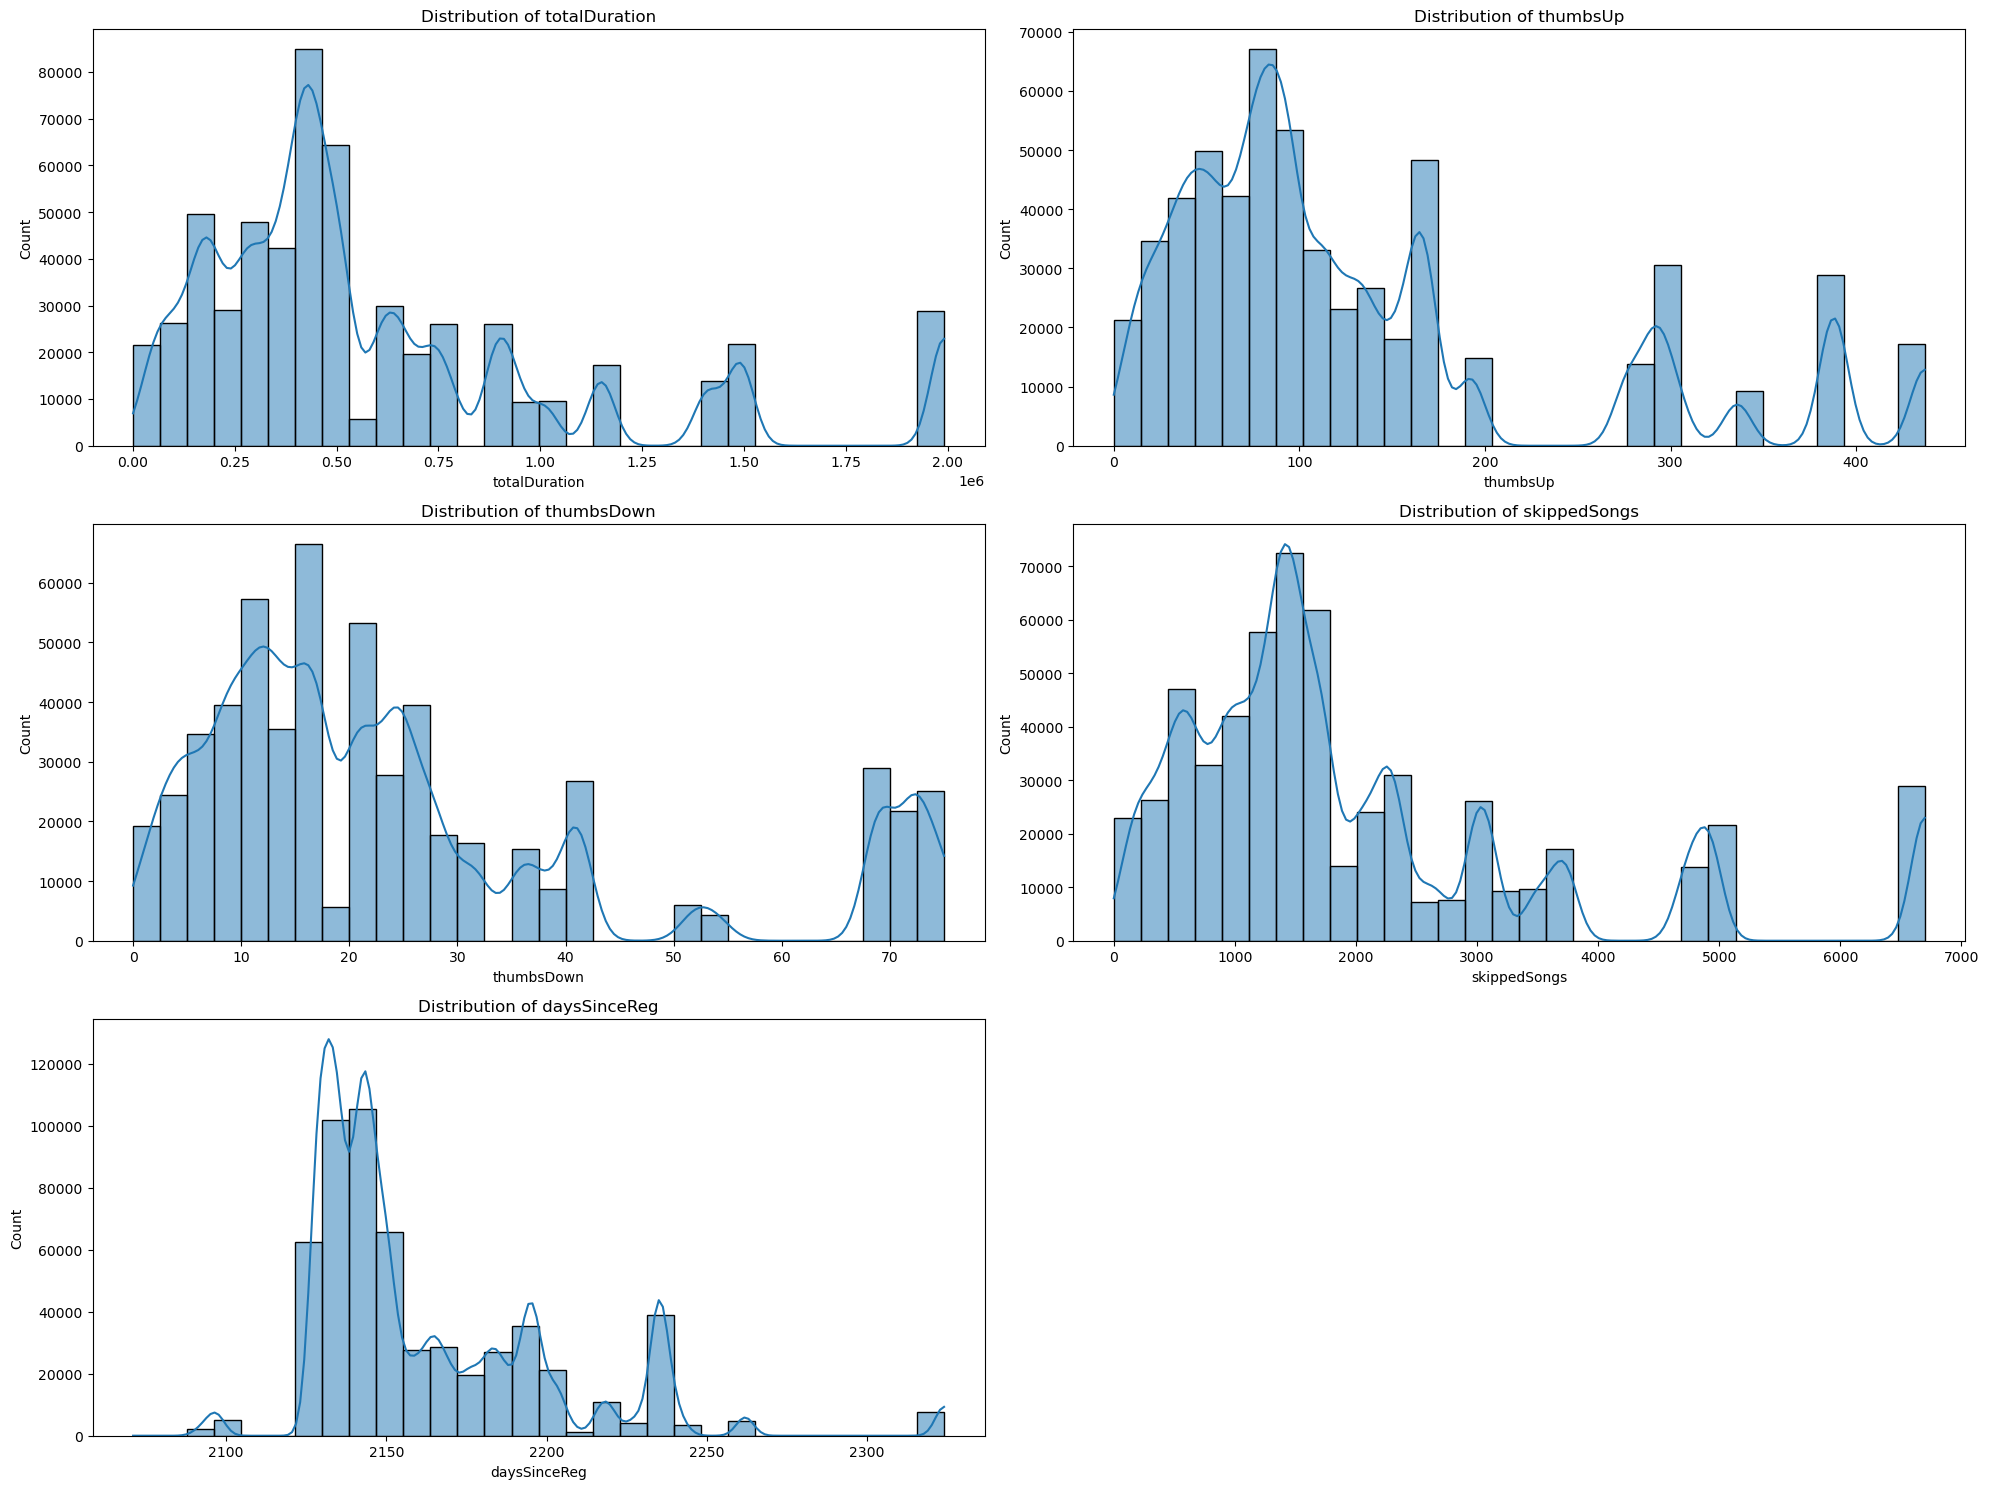

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for easier plotting
df_pd = df_clean.select('totalDuration', 'thumbsUp', 'thumbsDown', 'skippedSongs', 'daysSinceReg', 'genders', 'churn').toPandas()

# Plot histograms
features = ['totalDuration', 'thumbsUp', 'thumbsDown', 'skippedSongs', 'daysSinceReg']
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.histplot(df_pd[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


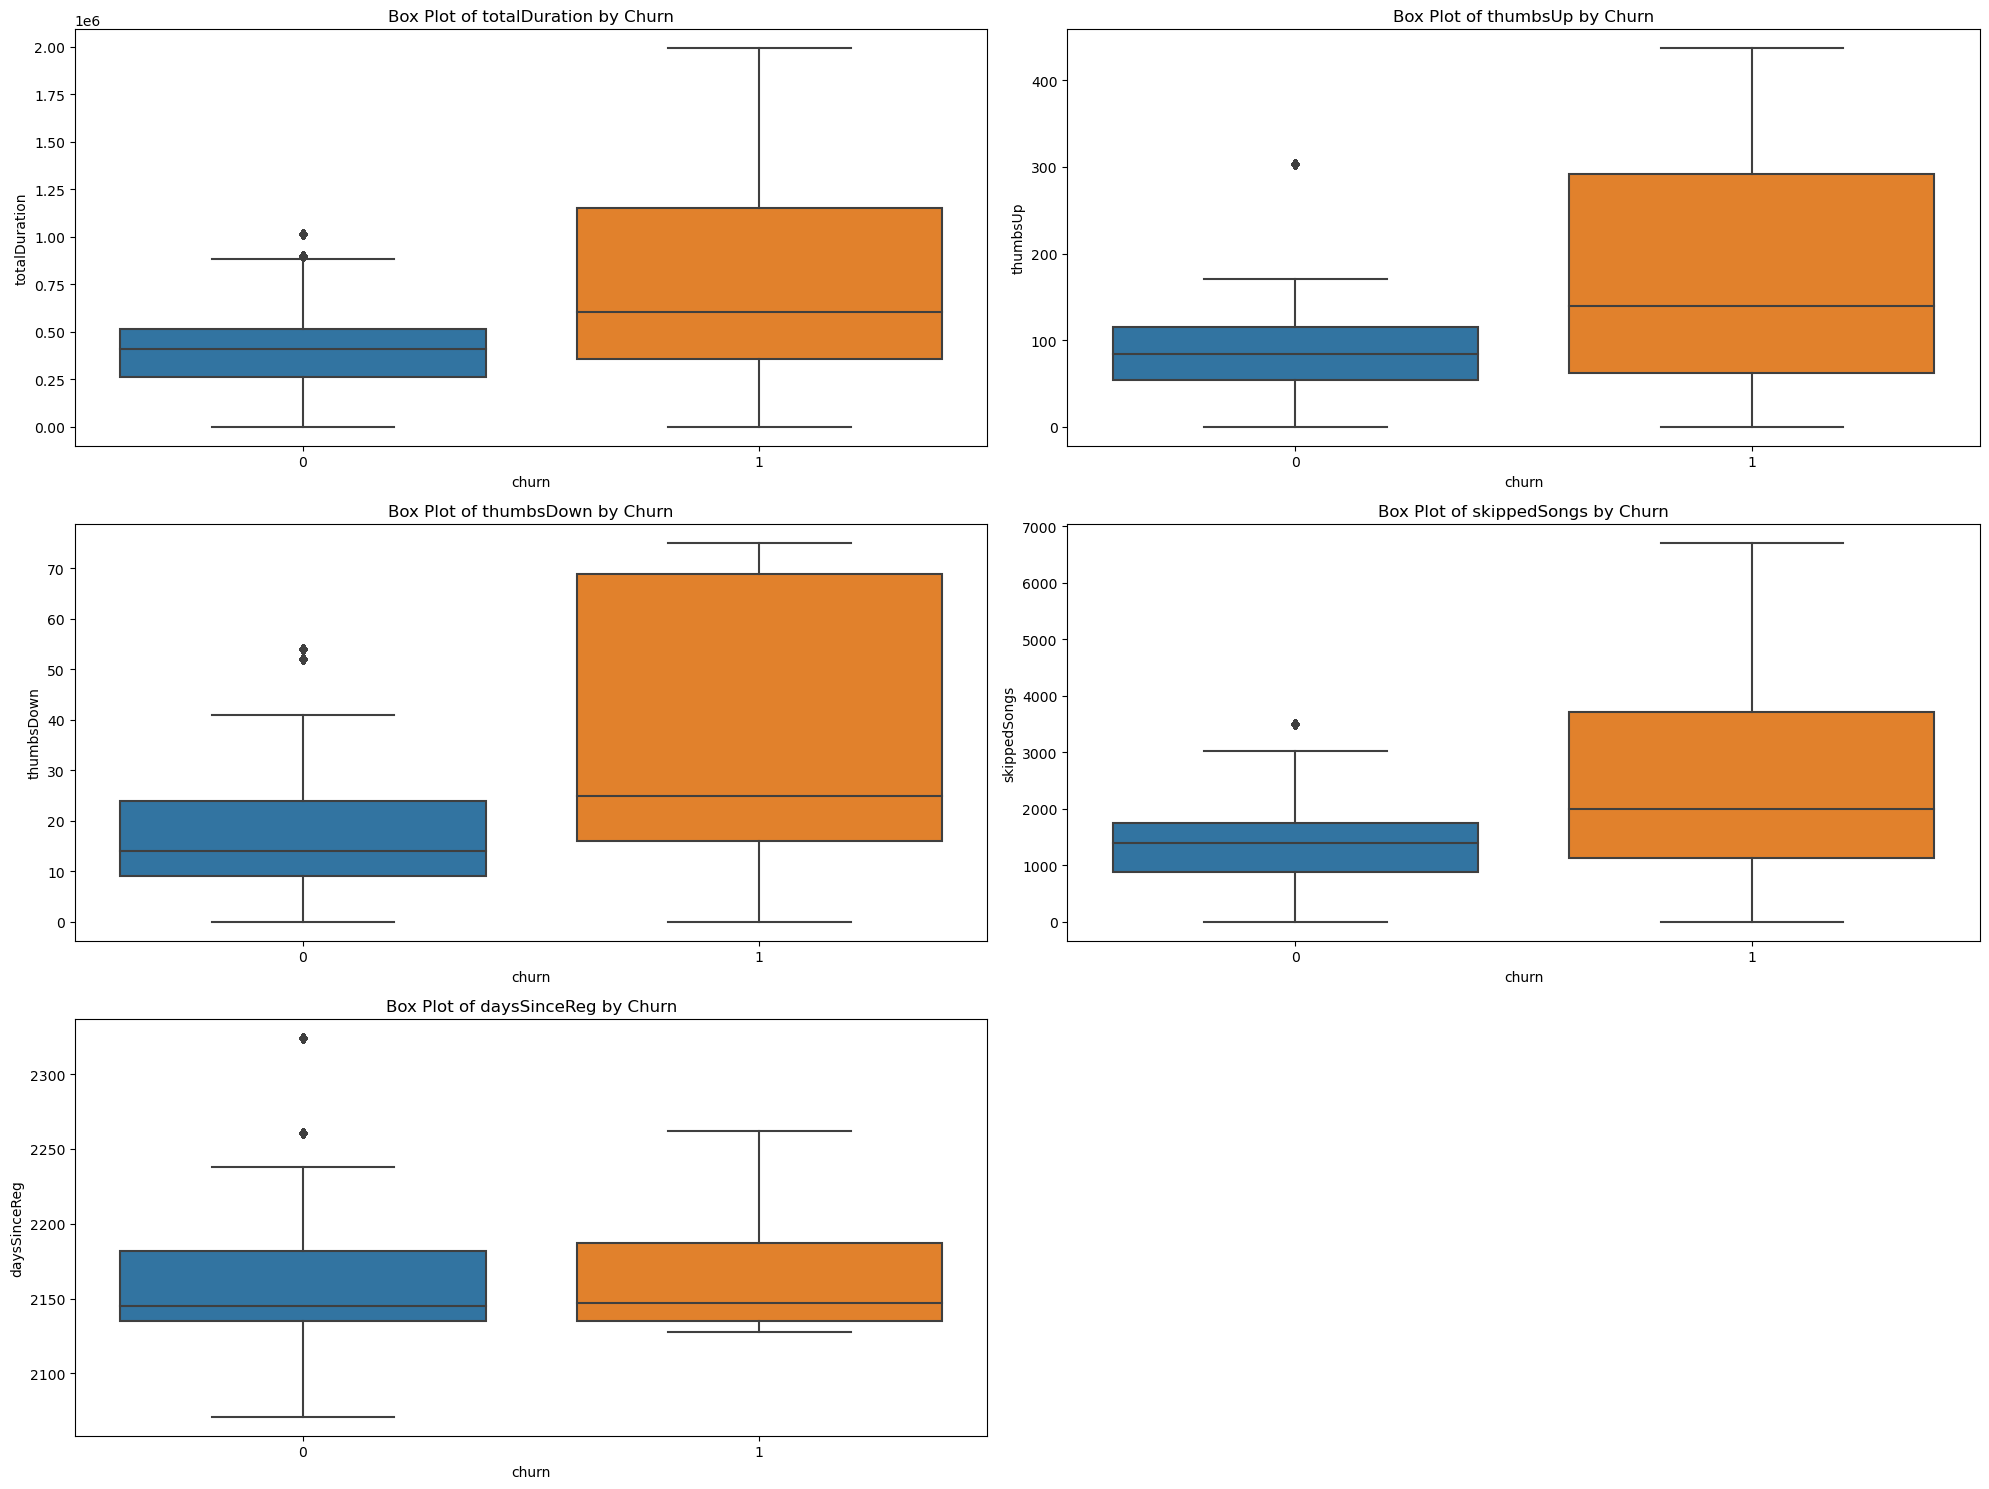

In [73]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x='churn', y=feature, data=df_pd)
    plt.title(f'Box Plot of {feature} by Churn')
plt.tight_layout()
plt.show()


In [88]:
#df_clean = df_clean.withColumn('paid', F.when(level=="paid", 1).otherwise(0))
df_clean = df_clean.withColumn('paid', F.when(df_clean.level == "paid", 1).otherwise(0))

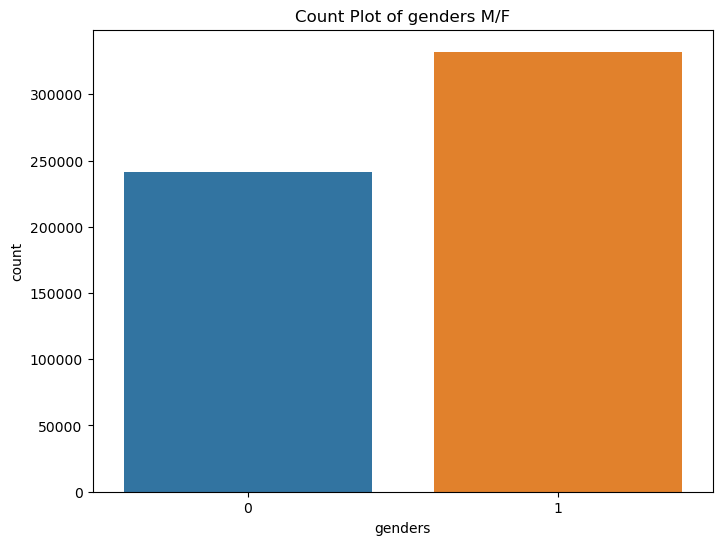

In [75]:
plt.figure(figsize=(8, 6))
sns.countplot(x='genders', data=df_pd)
plt.title('Count Plot of genders M/F')
plt.show()


In [89]:
#The schema of the dataframe to model
df_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- cancelled: integer (nullable = false)
 |-- downgrade: integer (nullable = false)
 |-- hour: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- sessionFreq: double (nullable = false)
 |-- maxInactivity: integer (nullable = true)
 |-- totalDuration

In [98]:
# List of columns to drop
columns_to_drop = [
    'artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 
    'length', 'level', 'location', 'method', 'page', 'registration', 
    'sessionId', 'song', 'status', 'userAgent', 'cancelled', 'downgrade', 
    'hour', 'date', 'sessionFreq', 'maxInactivity', 'month', 'month', 
    'seasonalActivity', 'features'
]


In [99]:
# Drop the unnecessary columns
df_clean = df_clean.drop(*columns_to_drop)

# Show the schema of the DataFrame to confirm
df_clean.printSchema()

# Show a sample of the DataFrame to confirm
df_clean.show(10, truncate=False)


root
 |-- userId: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- churn: integer (nullable = true)
 |-- totalDuration: double (nullable = false)
 |-- thumbsUp: long (nullable = true)
 |-- thumbsDown: long (nullable = true)
 |-- skippedSongs: long (nullable = true)
 |-- daysSinceReg: integer (nullable = true)
 |-- genders: integer (nullable = false)
 |-- paid: integer (nullable = false)

+------+-------------+-----+-------------+--------+----------+------------+------------+-------+----+
|userId|ts           |churn|totalDuration|thumbsUp|thumbsDown|skippedSongs|daysSinceReg|genders|paid|
+------+-------------+-----+-------------+--------+----------+------------+------------+-------+----+
|100   |1538492662000|1    |672877.85659 |148     |27        |2258        |2132        |0      |1   |
|100   |1538492662000|1    |672877.85659 |148     |27        |2258        |2132        |0      |1   |
|100   |1538492899000|1    |672877.85659 |148     |27        |2258        |2132       

In [100]:
#### Preparing Feautures


from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Drop the duplicate 'month' column
#df_clean = df_clean.drop('month')

# Handle missing values by filling or dropping them (example: filling with -1)
df_clean = df_clean.fillna(-1)

In [102]:
from pyspark.ml.feature import VectorAssembler

# List of 10 selected numerical features
input_cols = [
    'thumbsDown', 'paid' , 'thumbsUp', 'ts', 
    'totalDuration', 'skippedSongs', 'daysSinceReg', 'genders'
]

# Drop the existing 'features' column if it exists
if 'features' in df_clean.columns:
    df_clean = df_clean.drop('features')
# Create the VectorAssembler with the selected input columns
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Transform the dataframe to include the 'features' column
df_clean = assembler.transform(df_clean)

# Show the first 10 rows to verify the result
df_clean.select('features').show(10, truncate=False)


+-------------------------------------------------------------------+
|features                                                           |
+-------------------------------------------------------------------+
|[21.0,1.0,100.0,1.538398632E12,523275.8428000001,1827.0,2131.0,0.0]|
|[21.0,1.0,100.0,1.538398649E12,523275.8428000001,1827.0,2131.0,0.0]|
|[21.0,1.0,100.0,1.538398938E12,523275.8428000001,1827.0,2131.0,0.0]|
|[21.0,1.0,100.0,1.538399167E12,523275.8428000001,1827.0,2131.0,0.0]|
|[21.0,1.0,100.0,1.538399351E12,523275.8428000001,1827.0,2131.0,0.0]|
|[21.0,1.0,100.0,1.538399495E12,523275.8428000001,1827.0,2131.0,0.0]|
|[21.0,1.0,100.0,1.538399843E12,523275.8428000001,1827.0,2131.0,0.0]|
|[21.0,1.0,100.0,1.538400086E12,523275.8428000001,1827.0,2131.0,0.0]|
|[21.0,1.0,100.0,1.538400309E12,523275.8428000001,1827.0,2131.0,0.0]|
|[21.0,1.0,100.0,1.538400621E12,523275.8428000001,1827.0,2131.0,0.0]|
+-------------------------------------------------------------------+
only showing top 10 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [103]:
# Split the data into training and test sets
train, test = df_clean.randomSplit([0.8, 0.2], seed=42)

# Cache the splits
train.cache()
test.cache()

DataFrame[userId: string, ts: bigint, churn: int, totalDuration: double, thumbsUp: bigint, thumbsDown: bigint, skippedSongs: bigint, daysSinceReg: int, genders: int, paid: int, features: vector]

In [104]:
# Train and evaluate models
def evaluate_model(model, train, test, labelCol='churn', predictionCol='prediction'):
    # Fit the model on the training data
    model_fit = model.fit(train)
    # Make predictions on the test data
    predictions = model_fit.transform(test)
    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, predictionCol=predictionCol, metricName='f1')
    f1_score = evaluator.evaluate(predictions)
    return f1_score


In [105]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

# Initialize and evaluate Logistic Regression model
lr = LogisticRegression(labelCol='churn', featuresCol='features', maxIter=10)
lr_f1 = evaluate_model(lr, train, test)
print(f'Logistic Regression F1 Score: {lr_f1}')



Logistic Regression F1 Score: 0.6802240370274961


In [106]:
# Initialize and evaluate Decision Tree model
dt = DecisionTreeClassifier(labelCol='churn', featuresCol='features')  
dt_f1 = evaluate_model(dt, train, test)
print(f'Decision Tree F1 Score: {dt_f1}')



Decision Tree F1 Score: 0.8030399458184927


In [107]:
# Initialize and evaluate Random Forest model
rf = RandomForestClassifier(labelCol='churn', featuresCol='features', numTrees=50)
rf_f1 = evaluate_model(rf, train, test)
print(f'Random Forest F1 Score: {rf_f1}')


Random Forest F1 Score: 0.8690172501585121


In [97]:

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol='churn', numTrees=100, maxDepth=10)

# Train the RandomForest model
rf_model = rf.fit(train)

# Make predictions on the test set
rf_predictions = rf_model.transform(test)

# Evaluate the RandomForest model using accuracy
rf_accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='accuracy')
rf_accuracy = rf_accuracy_evaluator.evaluate(rf_predictions)

print(f"Random Forest Model Accuracy: {rf_accuracy}")

# Get feature importances
rf_feature_importances = rf_model.featureImportances

# Define the input columns used in the VectorAssembler
input_columns = [
    'thumbsDown','paid', 'thumbsUp', 'ts', 'registration', 
    'totalDuration', 'skippedSongs', 'daysSinceReg', 'genders'
]

# Print feature importances
print("Feature Importances:")
for i, feature in enumerate(input_columns):
    print(f"{feature}: {rf_feature_importances[i]}")


Random Forest Model Accuracy: 0.9912358805146738
Feature Importances:
thumbsDown: 0.24441850287195838
paid: 0.009432717914188236
thumbsUp: 0.18623481738395234
ts: 0.02523517729297783
registration: 0.09891946110469428
totalDuration: 0.16247196481702966
skippedSongs: 0.15912489149761225
daysSinceReg: 0.09303934524114855
genders: 0.021123121876438517


In [85]:
## Optmising the F1 score of the best model..
# Initialize and evaluate Random Forest model
rf = RandomForestClassifier(labelCol='churn', featuresCol='features', numTrees=10)
rf_f1 = evaluate_model(rf, train, test)
print(f'Random Forest F1 Score: {rf_f1}')

Random Forest F1 Score: 0.8855349163186825


In [86]:
# Initialize and evaluate Random Forest model
rf = RandomForestClassifier(labelCol='churn', featuresCol='features', numTrees=30)
rf_f1 = evaluate_model(rf, train, test)
print(f'Random Forest F1 Score: {rf_f1}')

Random Forest F1 Score: 0.8650596682755829


In [92]:


# Function to train and evaluate models
def train_and_evaluate_models(train, test):
    results = []
    
    # Logistic Regression
    lr = LogisticRegression(labelCol='churn', featuresCol='features')
    lr_model = lr.fit(train)
    lr_predictions = lr_model.transform(test)
    lr_f1 = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='f1').evaluate(lr_predictions)
    lr_accuracy = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='accuracy').evaluate(lr_predictions)
    results.append(('Logistic Regression', lr_f1, lr_accuracy))
    
    # Random Forest Classifier
    rf = RandomForestClassifier(labelCol='churn', featuresCol='features', numTrees=100)
    rf_model = rf.fit(train)
    rf_predictions = rf_model.transform(test)
    rf_f1 = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='f1').evaluate(rf_predictions)
    rf_accuracy = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='accuracy').evaluate(rf_predictions)
    results.append(('Random Forest', rf_f1, rf_accuracy))
    
    # Gradient-Boosted Trees Classifier
    gbt = GBTClassifier(labelCol='churn', featuresCol='features', maxIter=100)
    gbt_model = gbt.fit(train)
    gbt_predictions = gbt_model.transform(test)
    gbt_f1 = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='f1').evaluate(gbt_predictions)
    gbt_accuracy = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='accuracy').evaluate(gbt_predictions)
    results.append(('Gradient-Boosted Trees', gbt_f1, gbt_accuracy))
    
    return results



In [93]:
# Train and evaluate models
model_results = train_and_evaluate_models(train, test)
model_results


[('Logistic Regression', 0.7370145965154, 0.7376874596274376),
 ('Random Forest', 0.8559058915440875, 0.8576878087955446),
 ('Gradient-Boosted Trees', 0.9967006200441453, 0.9967003613889908)]

In [94]:
import pandas as pd

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(model_results, columns=['Model', 'F1 Score', 'Accuracy'])
print(results_df)


                    Model  F1 Score  Accuracy
0     Logistic Regression  0.737015  0.737687
1           Random Forest  0.855906  0.857688
2  Gradient-Boosted Trees  0.996701  0.996700


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.